In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from googleapiclient.discovery import build

In [2]:
API_KEY = os.environ["YOUTUBE_API_KEY"]
youtube = build("youtube", "v3", developerKey=API_KEY)

In [3]:
def get_channel_id(service, username):
    response = service.channels().list(
        part="contentDetails,statistics",
        forUsername=username
    ).execute()
    return response["items"][0]["id"]

In [4]:
CHANNEL_ID = get_channel_id(youtube, "Felixje0")

In [5]:
def get_upload_id(service, channel_id):
    response = service.channels().list(
        part="contentDetails,statistics",
        id=channel_id
    ).execute()
    return response["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

In [6]:
UPLOAD_ID = get_upload_id(youtube, CHANNEL_ID)

In [7]:
def get_video_ids(service, upload_id):
    video_ids = []

    response = service.playlistItems().list(
        part="contentDetails",
        playlistId=upload_id,
        maxResults=50
    ).execute()

    for video in response["items"]:
        video_ids.append(video["contentDetails"]["videoId"])
    
    next_page_token = response.get("nextPageToken")
    while next_page_token:
        response = service.playlistItems().list(
            part="contentDetails",
            playlistId=upload_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()

        for video in response["items"]:
            video_ids.append(video["contentDetails"]["videoId"])

        next_page_token = response.get("nextPageToken")

    return video_ids

In [8]:
video_ids = get_video_ids(youtube, UPLOAD_ID)
len(video_ids)

3825

In [9]:
def get_video_details(service, video_ids):
    result = []
    for i in range(0, len(video_ids), 50):
        response = service.videos().list(
            part="snippet,statistics",
            id=",".join(video_ids[i:i+50])
        ).execute()

        for video in response["items"]:
            try:
                result.append({
                    "title": video["snippet"]["title"],
                    "published_at": video["snippet"]["publishedAt"],
                    "description": video["snippet"]["description"],
                    "view_count": video["statistics"]["viewCount"],
                    "like_count": video["statistics"]["likeCount"],
                    "comments": video["statistics"]["commentCount"],
                })
            except Exception as _:
                result.append({
                    "title": video["snippet"]["title"],
                    "published_at": video["snippet"]["publishedAt"],
                    "description": video["snippet"]["description"],
                    "view_count": video["statistics"]["viewCount"],
                    "like_count": video["statistics"]["likeCount"],
                    "comments": 0,
                })
    df = pd.DataFrame(result)
    df["published_at"] = pd.to_datetime(df["published_at"])
    df["view_count"] = pd.to_numeric(df["view_count"])
    df["like_count"] = pd.to_numeric(df["like_count"])
    df["comments"] = pd.to_numeric(df["comments"])
    
    return df

In [10]:
video_stats = get_video_details(youtube, video_ids)
video_stats

,title,published_at,description,view_count,like_count,comments
0,StarCraft 2: FIVE MOTHERSHIPS?! (Scarlett vs G...,2022-12-04 17:06:49+00:00,Very long game of professional StarCraft 2 bet...,28351,1291,133
1,StarCraft 2: INSANE Multi Tasking - Serral vs ...,2022-12-02 17:00:09+00:00,Best-of-5 series of top elvel StarCraft 2 betw...,67127,2069,171
2,StarCraft 2: Lambo DRONE RUSHES MaxPax! (Best-...,2022-12-01 15:00:32+00:00,Grand Finals of the StarCraft 2 ESL Open Cup 1...,53126,1870,104
3,StarCraft 2: The BIGGEST THROW of the Year?!,2022-11-30 15:00:07+00:00,Crazy game of StarCraft 2 between Demi (Zerg) ...,49358,1678,120
4,StarCraft 2: EXTREME MACRO - Reynor vs HeroMar...,2022-11-29 15:33:56+00:00,Professional game of StarCraft 2 between HeroM...,70033,2275,202
...,...,...,...,...,...,...
3820,"★ Starcraft 2 FPVOD First Person Live Game: ""Z...",2011-09-30 13:28:15+00:00,More LowkoTV\n▶ Subscribe | http://www.lowkotv...,3139,30,12
3821,"Starcraft II Study #3 - ""My Heart For The Swar...",2011-09-27 16:45:18+00:00,More LowkoTV\n▶ Subscribe | http://www.lowkotv...,5031,41,12
3822,"★ Starcraft 2 Master: ""Multiplayer 1v1 Analysi...",2011-09-23 02:14:23+00:00,More LowkoTV\n▶ Subscribe | http://www.lowkotv...,4188,33,7
3823,"Starcraft II Study #2 - ""My Heart For The Swar...",2011-09-22 05:57:47+00:00,More LowkoTV\n▶ Subscribe | http://www.lowkotv...,6102,85,21


In [11]:
video_stats.to_csv("lowko_video_stats.csv", index=False)

In [19]:
video_stats = pd.read_csv("lowko_video_stats.csv", index_col="published_at", parse_dates=True)
video_stats["month"] = video_stats.index.strftime("%B")
video_stats["year"] = video_stats.index.year
video_stats

,title,description,view_count,like_count,comments,month,year
published_at,,,,,,,
2022-12-04 17:06:49+00:00,StarCraft 2: FIVE MOTHERSHIPS?! (Scarlett vs G...,Very long game of professional StarCraft 2 bet...,28351,1291,133,December,2022
2022-12-02 17:00:09+00:00,StarCraft 2: INSANE Multi Tasking - Serral vs ...,Best-of-5 series of top elvel StarCraft 2 betw...,67127,2069,171,December,2022
2022-12-01 15:00:32+00:00,StarCraft 2: Lambo DRONE RUSHES MaxPax! (Best-...,Grand Finals of the StarCraft 2 ESL Open Cup 1...,53126,1870,104,December,2022
2022-11-30 15:00:07+00:00,StarCraft 2: The BIGGEST THROW of the Year?!,Crazy game of StarCraft 2 between Demi (Zerg) ...,49358,1678,120,November,2022
2022-11-29 15:33:56+00:00,StarCraft 2: EXTREME MACRO - Reynor vs HeroMar...,Professional game of StarCraft 2 between HeroM...,70033,2275,202,November,2022
...,...,...,...,...,...,...,...
2011-09-30 13:28:15+00:00,"★ Starcraft 2 FPVOD First Person Live Game: ""Z...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,3139,30,12,September,2011
2011-09-27 16:45:18+00:00,"Starcraft II Study #3 - ""My Heart For The Swar...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,5031,41,12,September,2011
2011-09-23 02:14:23+00:00,"★ Starcraft 2 Master: ""Multiplayer 1v1 Analysi...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,4188,33,7,September,2011


<AxesSubplot: xlabel='month', ylabel='view_count'>

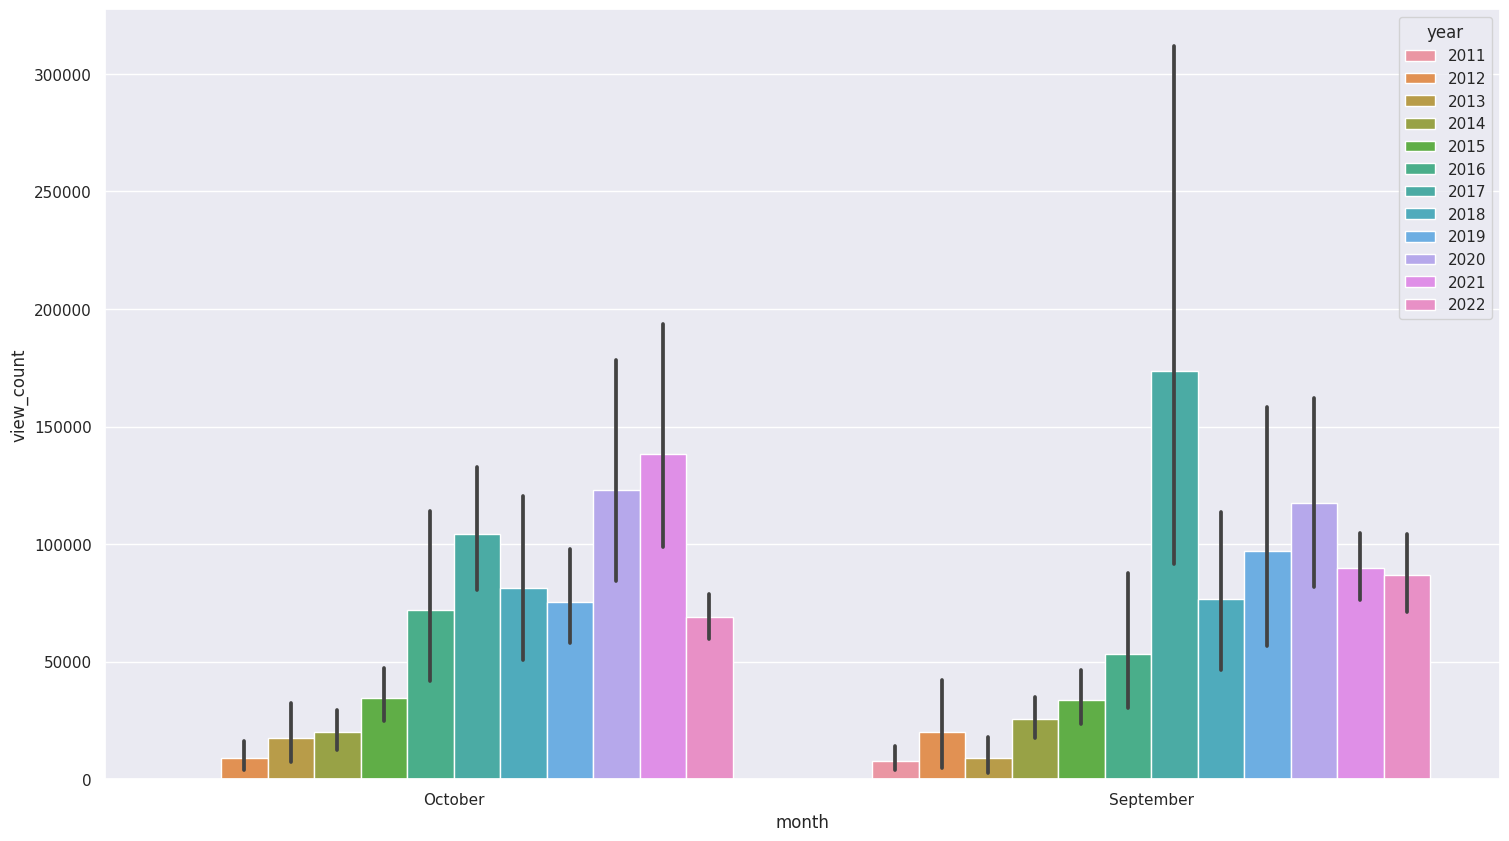

In [31]:
plt.figure(figsize=(18, 10))
sns.barplot(data=video_stats[video_stats["month"].isin(["September", "October"])], x="month", y="view_count", hue="year")

<AxesSubplot: xlabel='view_count', ylabel='Count'>

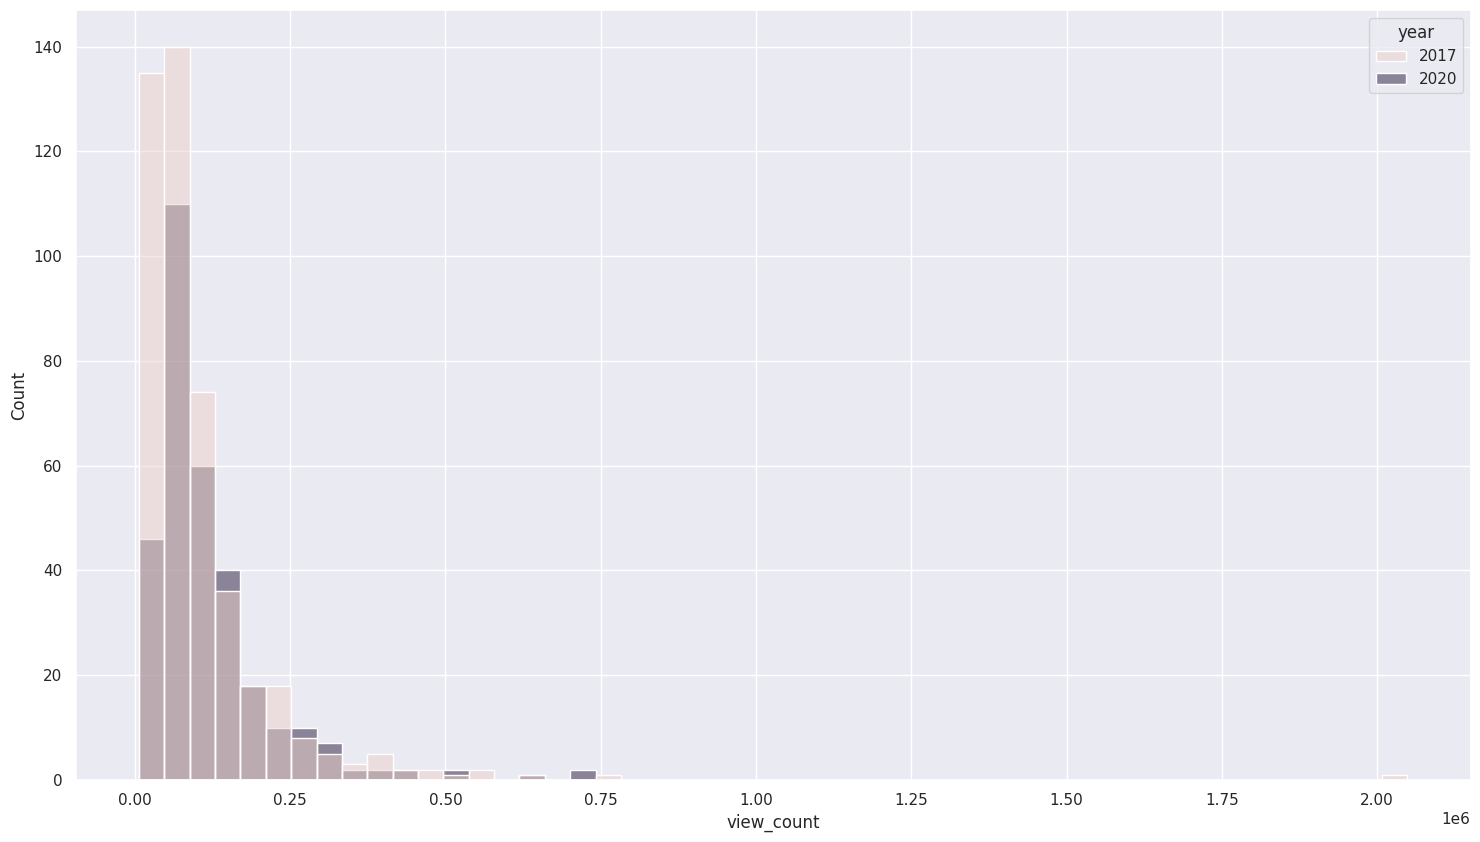

In [41]:
plt.figure(figsize=(18, 10))
sns.histplot(data=video_stats[video_stats["year"].isin([2017, 2020])], x="view_count", bins=50, hue="year")